<img src="images/JHI_STRAP_Web.png" style="width: 150px; float: right;">

# Supplementary Information: Holmes *et al.* 2017

# 4. *etpD* knockouts and complementation

This notebook describes raw data import, cleaning and QA, then modelling of the *etpD* knockout and complementation experiments.

## Table of Contents

 1. [Experiment design](#design)
 2. [Data import](#import_data)
    1. [Process data](#process)
    2. [Inspect raw data](#inspect)   
 3. [Model definition](#definition)
    1. [Measured values of logCFU](#values)
    2. [Linear model parameters](#parameters)
    3. [Choice of priors](#priors)
    4. [Stan model construction](#stan)
 4. [Model fit](#fit)
    1. [Leaf tissue](#leaf_fit)
    2. [Root tissue](#root_fit)

## Python imports

These dependencies are required to run the code in this notebook.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystan

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context('notebook')
plt.rcParams['figure.figsize'] = (12, 8)

import warnings
warnings.filterwarnings('ignore')

## 1. Experiment design <a id="design"></a>

The experiments comprise four variants of *E. coli* Sakai:

1. Wild Type (`WT`)
2. *etpD* knockouts: ΔetpD (`KO`)
3. empty plasmid pSE380: (`empty`)
4. plasmid pSE380 carrying *etpD* complement: (`complement`)

The variants can be considered to be *nested* in that they are stepwise changes to the composition of the bacterium being tested. The `KO` variant can be considered to modify baseline `WT` adherence (by deletion of the *etpD* gene). The `empty` variant can be considered to modify the adherence properties of the `KO` variant (by introducing an empty pSE380 plasmid to the knockout background). The `complement` variant can be considered to modify the adherence properties of the `empty` variant (by introducing the *etpD* gene into the pSE380 plasmid, in the knockout background).

These four variants are each and separately exposed to two spinach plant tissues: *leaf* and *root*, and logCFU of recovered bacteria measured as a proxy for adherence, as described in the manuscript.

The questions at hand are:

1. Is there a difference in logCFU for `KO` with respect to `WT`? If so, what is the direction and magnitude of change?
2. Is there a difference in logCFU for `complement` with respect to `empty`? If so, what is the direction and magnitude of this change?

Measurements were made in batches of five. That is, on a particular half-day a batch of ten measurements were made: five `KO` and five `WT`; or five `empty` and five `complement`. There is therefore **no natural pairing of `WT`/`KO` to `empty`/`complement` measurements** as these were carried out in different batches at different times. We may assume that each batch is subject to specific effects that may bias the observed logCFU with respect to other batches, and that this effect is consistent for all treatments applied to that batch.

For each tissue, the experiments were conducted such that each logCFU measurement was acquired on a single, independent root or leaf. This means that there is **no natural pairing of specific `WT` and `KO`, or `empty` and `complement` measurements**. The natural comparison is therefore within-batch, and pooled.

## 2. Data import <a id="import_data"></a>

<div class="alert alert-warning">
Raw data was previously converted to plain text comma-separated variable format from the `Excel` file `../data/etpD/etpD_raw_data.xlsx`:

<ul>
<li> The file `../data/etpD/leaves.csv` contains data from experiments on spinach leaves
<li> The file `../data/etpD/roots.csv` contains data from experiments on spinach roots
</ul>
</div>

We import the data using `pandas`, and show the first few lines:

In [2]:
# Raw data locations
leafdatafile = "../data/etpD/leaves.csv"
rootdatafile = "../data/etpD/roots.csv"

# Parse data
leafdata = pd.read_csv(leafdatafile)
rootdata = pd.read_csv(rootdatafile)

In [3]:
# Show leaf data
leafdata.head()

,Sakai,delta EtpD,pSE380,pSE_EtpD
0,1.496078e+06,424092.4092,7.414966e+05,3288288.288
1,9.719888e+05,122362.8692,2.788462e+06,4272300.469
2,1.614790e+06,451790.6336,4.020619e+05,2897435.897
3,6.333333e+05,894444.4444,4.341564e+05,2933333.333
4,1.228175e+06,676767.6768,7.233010e+05,1450396.825


In [4]:
# Show root data
rootdata.head()

,Sakai,delta EtpD,pSE380,pSE_EtpD
0,4750000.000,852564.1026,439814.8148,662162.1622
1,2000000.000,666666.6667,588652.4823,569230.7692
2,2166666.667,757894.7368,699530.5164,154166.6667
3,4927536.232,618618.6186,682051.2821,565040.6504
4,5714285.714,973856.2092,628415.3005,307692.3077


### Process data<a id="process"></a>

The raw data are, as described above, divisible into batches of five as separate (`Sakai`/`WT`; `delta EtpD`/`KO`) and (`pSE380`/`empty`; `pSE_EtpD`/`complement`) results. We need to convert the data from wide to long form, creating a categorical factors to describe the four treatments.

We also introduce three further factors: `KO`, `empty`, and `complement`, so that these describe the cumulative modifications to Sakai as a series of `0/1` values. This will be important for our model, below.

* `Sakai`: `KO`:0, `empty`:0, `complement`:0
* `delta EtpD`: `KO`:1, `empty`:0, `complement`:0
* `pSE380`: `KO`:1, `empty`:1, `complement`:0
* `pSE_EtpD`: `KO`:1, `empty`:1, `complement`:1

and introduce a further `batch` identifier, uniquely numbering batches from $1 \ldots n$ in blocks of five rows.

In [5]:
def wide_to_long(df):
    """Convert wide form array to long form array.
    
    Assumes the columns are in order: Sakai, delta EtpD, pSE380,
    pSE_EtpD.
    
    Splits the data into two tables: Sakai and delta Etpd;
    pSE380 and pSE_EtpD. Adds a column `batch` and fills this
    incrementally in groups of five, *not* repeating batch
    number across the two tables.
    
    Then the tables are melted with all data values in a single
    column headed CFU, and the batch column retained. The tables
    are joined row-wide (Sakai/EtpD table on top).
    
    New columns are added: KO, pSE380, etpD. These columns are
    filled as 1/0 depending on the originating column for the
    value:
    
    - first 25% of rows are 0, 0, 0
    - next 25% of rows are 1, 0, 0
    - next 25% of rows are 1, 1, 0
    - next 25% of rows are 1, 1, 1
    """
    # Split data
    df1 = df[['Sakai', 'delta EtpD']]
    df2 = df[['pSE380', 'pSE_EtpD']]
    
    # Assign batches
    for idx, dfn in enumerate([df1, df2]):
        dfn['batch'] = (np.floor(np.array(dfn.index)/5) + 1).astype(int)
        dfn['batch'] = (dfn['batch'] + (len(dfn)/5 * idx)).astype(int)

    # wide to long
    df1 = pd.melt(df1, id_vars=['batch'], value_vars=['Sakai', 'delta EtpD'])
    df2 = pd.melt(df2, id_vars=['batch'], value_vars=['pSE380', 'pSE_EtpD'])
 
    # Concatenate dataframes lengthwise and rename headers
    df = pd.concat([df1, df2])
    df.columns = ['batch', 'label', 'CFU']
    
    # Add factors
    df['KO'] = [0] * int(0.25 * len(df)) + [1] * int(0.75 * len(df))
    df['empty'] = [0] * int(0.5 * len(df)) + [1] * int(0.5 * len(df))    
    df['complement'] = [0] * int(0.75 * len(df)) + [1] * int(0.25 * len(df))
    
    # Convert values to log_10 values
    df['logCFU'] = np.log10(df['CFU'])
    
    # Make factors categorical
    for col in ['batch', 'KO', 'empty', 'complement', 'label']:
        df[col] = df[col].astype('category')
    
    return df

In [6]:
# Convert data from wide to long
leafdata = wide_to_long(leafdata)
rootdata = wide_to_long(rootdata)

In [7]:
# Show leaf data
leafdata.head()

,batch,label,CFU,KO,empty,complement,logCFU
0,1,Sakai,1.496078e+06,0,0,0,6.174954
1,1,Sakai,9.719888e+05,0,0,0,5.987661
2,1,Sakai,1.614790e+06,0,0,0,6.208116
3,1,Sakai,6.333333e+05,0,0,0,5.801632
4,1,Sakai,1.228175e+06,0,0,0,6.089260


In [8]:
# Show root data
rootdata.head()

,batch,label,CFU,KO,empty,complement,logCFU
0,1,Sakai,4750000.000,0,0,0,6.676694
1,1,Sakai,2000000.000,0,0,0,6.301030
2,1,Sakai,2166666.667,0,0,0,6.335792
3,1,Sakai,4927536.232,0,0,0,6.692630
4,1,Sakai,5714285.714,0,0,0,6.756962


### Inspect raw data<a id="inspect"></a>

We can visualise the data for root and leaf applications to see trends, such as whether there are batch effects that need to be considered and accounted for in the statistical model.

Plotting the leaf data below, we can see that there is a clear difference between batches 1 and 2 for any condition, but little difference between batches 3 and 4. This suggests that we must account for batch effects for this dataset.

Unfortunately, as only two batch-level replicates for each condition are available, we cannot determine from inspection alone whether batch 1 measurements are lower with respect to an accurate batch 2, or whether batch 2 measurements are higher with respect to an accurate batch 1. However, by: (i) constructing an appropriate model of the system and taking into account that the conditions represent successive modifications to the baseline recovery of `Sakai` we can 'borrow' information about baseline recovery from all measurements in this dataset; and (ii) noting that 6.5 logCFU is a typical recovery of bacteria from leaf material, we can apply suitable prior assumptions in our statistical model. This will allow us to infer values for the batch effects alongside the biological effects we seek to answer questions (1) and (2) above.

Batch effects notwithstanding, it appears initially that knocking out *etpD* reduces the amount of bacteria recovered from leaf tissue, while introducing the *etpD* complement in the knockout background increases the level of recovery with respect to the empty vector.

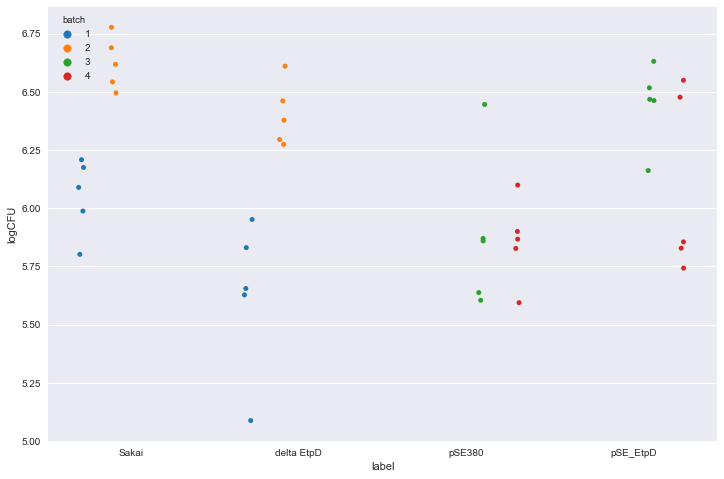

In [9]:
# Plot leaf data by treatment, split by batch
ax = sns.stripplot(x='label', y='logCFU', hue='batch',
                   data=leafdata,
                   jitter=True, dodge=True)

Plotting the root data, similar batch-level effects can again be observed (measurements in batches 1, 2 and 5 appear to be suppressed in relation to the other batches). As before, using a suitable model of the system that includes batch effects, and applying reasonable priors, it shall be possible to infer both batch effect and biological effect sizes simultaneously from this dataset.

Initially, it appears that, in root tissue, knockout of *etpD* results in reduced recovery from roots, but reintroduction of *etpD* in a knockout background does not increase recovery levels with respect to the empty vector.

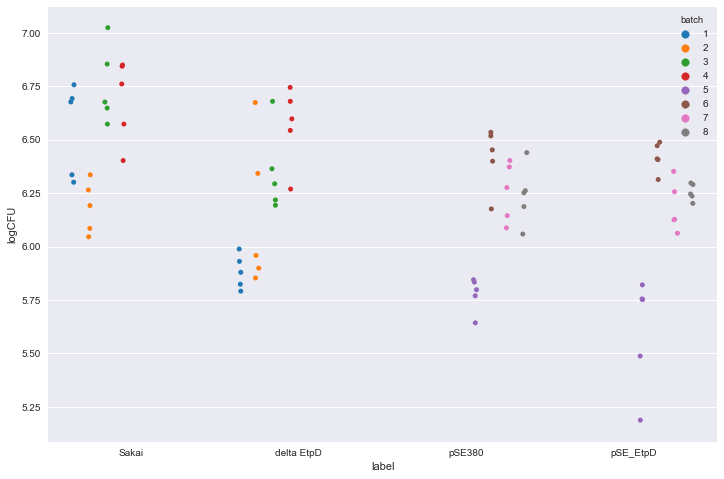

In [10]:
# Plot root data by treatment, split by batch
ax = sns.stripplot(x='label', y='logCFU', hue='batch',
                   data=rootdata,
                   jitter=True, dodge=True)

## 3. Model definition <a id="definition"></a>

In this section, we will define the statistical model that will be used to infer four key biologically-relevant values for each of the two tissues:

1. The expected level of recovery (logCFU) of wild-type Sakai
2. The expected change in recovery (logCFU) of Sakai with respect to wild-type if the *etpD* gene is knocked out 
3. The expected change in recovery (logCFU) when the pSE380 empty vector is introduced, with respect to the $\Delta etpD$ knockout
4. The expected change in recovery (logCFU) with respect to the knockout carrying empty vector, if the pSE380 vector carries the *etpD* gene

The model will also infer a value for each of the distinct batches of measurements in the dataset:

* The expected difference in recovery (logCFU) due to the sample being measured in that batch

### Measured values of logCFU<a id="values"></a>

With the logCFU measurements presented in long form, as above, each measurement is assigned a unique identifying number $i \in 1, 2 \ldots k$, where $k$ is the total number of measurements.

We assume that each measurement with index *i* measures the logCFU (proxy for extent of adherence/attachment) of a particular Sakai variant when recovered from plant tissue. We define the measured value as the *output* $y_{i}$, and assume that it represents a true value of logCFU (which we call $\hat{y_{i}}$) plus some irreducible error in the measurement ($\epsilon$). The error in measurement is assumed to be the same for all measurements, and we assume it is normally-distributed with mean 0 and variance $\sigma^{2}_{y}$.

$$y_i = \hat{y_i} + \epsilon_i$$
$$\epsilon_i \sim N(0, \sigma_y^2) \implies y_i \sim N(\hat{y_i}, \sigma_y^2)$$

We assume that the 'true' value $\hat{y_{i}}$ is determined by the following factors:

1. The *baseline* tendency of the `WT` wild-type variant to adhere to the tissue (shared by all datapoints)
2. Modification of (1) by the specific loss of *etpD*
3. Modification of (2) by the presence of plasmid pSE380
4. Modification of (3) by the presence of *etpD* on plasmid pSE380
5. Effects specific to the batch being run.

We assume that the effects of these factors are *additive* only, do not interact in complex ways, and can be combined into a *linear model*.

### Linear model parameters<a id="parameters"></a>

The *baseline* factor (1) is represented as the parameter $\alpha$. This influences all measurements $i$.

The other factors (2)-(4) represent modifications to the baseline, each with its own parameter ($\beta$, $\gamma$, $\delta$). Any one of these influences only a subset of measurements, and whether a measurement is influenced by one of these factors can be coded as `1/0` integer values. In the long-form table above these are found in columns `KO`, `empty` and `complement`. For the purposes of formally defining our model, we refer to these instead as $t$, $u$ and $v$. The measurement with index $i$ therefore has corresponding values $t_i$, $u_i$, and $v_i$. 

Splitting the factors in this way enables 'borrowing' of data from the plasmid-bearing variants for the estimate of the effect due to loss of *etpD*. Similarly, it enables the direct estimation of the effect of reintroducing *etpD* as a complement. With this interpretation, the parameters $\beta$, $\gamma$ and $\delta$ have the meanings:

* $\beta$ - the change in logCFU due to loss of *etpD* with respect to the wild type
* $\gamma$ - the change in logCFU due to incorporation of the pSE380 plasmid. Note that as there is no experiment in which the wild-type Sakai carries this plasmid, this parameter only estimates the effect in a $\Delta etpD$ background.
* $\delta$ - the change in logCFU due to incorporation of *etpD* on the pSE380 plasmid. Note again that this parameter only estimates the effect with respect to a $\Delta etpD$ Sakai background carrying an empty pSE380 plasmid, due to the experiment structure.

The collection of batch effect factors (5) can be represented as an array of parameters, $\phi_{j_{i}}$, where $j \in {1, 2, \ldots, n}$ and $n$ is the number of batches. Each value of $\phi_{j_{i}}$ represents the common effect on all measurements in batch $j_{i}$ - the batch to which measurement $i$ belongs - due to being in that batch. It is a non-biological effect.

We choose to model each of the parameters as additive effects, cumulatively acting upon the baseline adherence $\alpha$. Effects that diminish recovery should have negative values for their parameters; effects that enhance recovery should have positive values for their parameters. Effects for which their parameter's credibility interval spans zero will not be considered to have been shown convincingly to have any effect.

### Choice of priors<a id="priors"></a>

For each biological effect, we choose the parameter's *prior distribution* to be a Normal distribution, as we expect conservative behaviour and no extreme outliers. Our goal here is to reasonably constrain the estimated parameters to biologically plausible values, without being overly prescriptive. Our model will estimate the mean value and dispersion of each parameter's *posterior distribution*:

$$\alpha \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\beta \sim N(\mu_{\beta}, \sigma_{\beta}^2)$$
$$\gamma \sim N(\mu_{\gamma}, \sigma_{\gamma}^2)$$
$$\delta \sim N(\mu_{\delta}, \sigma_{\delta}^2)$$

We have a strong prior belief about the expected distribution of $\alpha$. From the obtained raw data (and additional experiments) we expect the mean baseline of `logCFU` for wild-type Sakai to be somewhere around 6.5. This is represented in the prior distribution we choose for $\mu_{\alpha}$. The distribution is centred on 6.5 logCFU, and we assume one log unit variance in this:

$$\mu_{\alpha} \sim \textrm{N}(6.5, 1)$$

The variance of each parameter's *prior distribution* will be drawn from a *weak prior*, as we do not have strong beliefs about its value. We choose a half-Normal distribution with mean zero, and standard deviation of 1 log unit:

$$\sigma_\alpha \sim \textrm{N}(0, 1)$$
$$\sigma_\beta \sim \textrm{N}(0, 1)$$
$$\sigma_\gamma \sim \textrm{N}(0, 1)$$
$$\sigma_\delta \sim \textrm{N}(0, 1)$$

For batch effects $j_i$ (the batch from which measurement $i$ is drawn) we expect that the batch effect itself will be conservative and well-behaved, so represent this with a Normal distribution. Most batches will be fairly similar to the 'usual' measured value, so the effect of a batch (the *mean* of that distribution) is likely to be close to zero. However, we expect that occasionally a batch effect will be quite large, so we choose a *Cauchy distribution* to describe our prior for the mean, as it is Normal-like but has fat tails, so can take more extreme values more frequently. We expect the usual mean of this effect to be close to zero, so use $\textrm{Cauchy}(0, 0.2)$ as quite a strong prior against large batch effects. We select a weaker half-Normal prior for the variance of the batch effect itself $\sigma_{\phi_{j_{i}}}$:

$$j_i \in {1, 2, \ldots, 8}$$
$$\phi_{j_{i}} \sim N(\mu_{\phi_{j_{i}}}, \sigma_{\phi_{j_{i}}}^2)$$
$$\mu_{\phi_{j_{i}}} \sim \textrm{Cauchy}(0, 0.2)$$
$$\sigma_{\phi_{j_{i}}} \sim \textrm{Normal}(0, 1)$$

We need to take some care with the estimates of $\phi_{j_{i}}$ as it is a linear combination with $\alpha$, and these values can blow up in a complementary manner (very large values of one permit very large values of the other). Specifically, leaving $\mu_{\phi_{j_{i}}}$ weakly constrained can result in wildly unrealistic estimates of $\phi_{j_{i}}$ and $\alpha$ being possible. Conversely, we *do* expect at least one outlier, as biasing effects due to the batches are clearly visible. As a result, we constrained our priors so that $\mu_{\phi_{j_{i}}} \sim \textrm{Cauchy}(0, 0.2)$ to reflect our understanding that batch effects are typically close to zero, but can occasionally take large values.

<div class="alert-success">
<b>We therefore construct the following model of the experiment, for a given tissue:</b>

$$y_i = \hat{y_i} + \epsilon_i$$
$$\hat{y_i} = \alpha + \beta t_i + \gamma u_i + \delta v_i + \phi_{j_{i}}$$

$$j_i \in {1, 2, \ldots, 8}$$

$$\alpha \sim \textrm{N}(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\beta \sim \textrm{N}(\mu_{\beta}, \sigma_{\beta}^2)$$
$$\gamma \sim \textrm{N}(\mu_{\gamma}, \sigma_{\gamma}^2)$$
$$\delta \sim \textrm{N}(\mu_{\delta}, \sigma_{\delta}^2)$$
$$\phi_{j_{i}} \sim \textrm{N}(\mu_{\phi_{j_{i}}}, \sigma_{\phi_{j_{i}}}^2)$$

$$\mu_{\alpha} \sim \textrm{N}(6.5, 1)$$
$$\mu_{\phi_{j_{i}}} \sim \textrm{Cauchy}(0, 0.2)$$

$$\sigma_\alpha \sim \textrm{N}(0, 1)$$
$$\sigma_\beta \sim \textrm{N}(0, 1)$$
$$\sigma_\gamma \sim \textrm{N}(0, 1)$$
$$\sigma_\delta \sim \textrm{N}(0, 1)$$
$$\sigma_{\phi_{j_{i}}} \sim \textrm{N}(0, 1)$$

<ul>
<li> $y_i$: measured logCFU for a single application $i$ of bacteria to a plant
<li> $\hat{y_i}$: 'true' logCFU for a single application $i$ of bacteria to a plant
<li> $\epsilon_i$: measurement error in logCFU for a single application of $i$ of bacteria to a plant
<li> $\alpha$: the expected logCFU for wild-type (`WT`) Sakai to a plant
<li> $\mu_\alpha$: mean logCFU for `WT` Sakai on the plant
<li> $\sigma_\alpha$: variance logCFU for `WT` Sakai on the plant
<li> $\beta$: the expected modification of logCFU w.r.t. `WT` as the result of deletion of *etpD*
<li> $\mu_\beta$: mean change in logCFU for `KO` w.r.t. `WT` Sakai on the plant
<li> $\sigma_\alpha$: variance for change in logCFU for `KO` w.r.t. `WT` Sakai on the plant
<li> $t_i$: 0/1 pseudovariable indicating whether the strain used for $i$ is $\Delta etpD$ (is `KO`)
<li> $\gamma$: the expected modification of logCFU w.r.t. `KO` as the result of incorporation of plasmid pSE380
<li> $\mu_\gamma$: mean change in logCFU for `empty` w.r.t. `KO` Sakai on the plant
<li> $\sigma_\gamma$: variance for change in logCFU for `empty` w.r.t. `KO` Sakai on the plant
<li> $u_i$: 0/1 pseudovariable indicating whether the strain used for $i$ is $\Delta etpD$ and carrying pSE380 (is `empty`)
<li> $\delta$: the expected modification of logCFU w.r.t. `empty` as the result of complementation with *etpD*
<li> $\mu_\delta$: mean change in logCFU for `complement` w.r.t. `empty` Sakai on the plant
<li> $\sigma_\delta$: variance for change in logCFU for `complement` w.r.t. `empty` Sakai on the plant
<li> $v_i$: 0/1 pseudovariable indicating whether the strain used for $i$ is $\Delta etpD$, carrying pSE380, and includes the complemented *etpD* (is `complement`)
<li> $j_i$: the batch from which $i$ is drawn, $j \in {1, 2, \ldots, 8}$
<li> $\phi_{j_{i}}$: the expected modification of logCFU for batch $j_i$ w.r.t. `WT`
<li> $\mu_{\phi_{j_{i}}}$: mean change in logCFU for batch $j_i$ w.r.t. `WT`
<li> $\sigma_{\phi_{j_{i}}}$: variance for change in logCFU for batch $j_i$ w.r.t. `WT`
</div>

### Stan model construction<a id="stan"></a>

We need to define `data`, `parameters` and our `model` for `Stan`

#### `data` block

* `N`: `int` - number of datapoints
* `K`: `int` - number of batches
* `t`: `vector[N]` - 0/1 values for `KO`
* `u`: `vector[N]` - 0/1 values for `empty`
* `v`: `vector[N]` - 0/1 values for `complement`
* `batch`: `int[N]` - batch (`1:K`) from which each measurement is drawn
* `y`: `vector[N]` - the output logCFU values

#### `parameter` block

* `a`: `real` - estimated logCFU for `WT`
* `mu_a`: `real` - unconstrained value representing mean of Cauchy distribution underlying `a`
* `sigma_a`: `real<lower=0>` - standard deviation of Cauchy distribution underlying `a`
* `b`: `real` - estimated change in logCFU for `KO`
* `mu_b`: `real` - unconstrained value representing mean of Cauchy distribution underlying `b`
* `sigma_b`: `real<lower=0>` - standard deviation of Cauchy distribution underlying `b`
* `c`: `real` - estimated change in logCFU for `empty`
* `mu_c`: `real` - unconstrained value representing mean of Cauchy distribution underlying `c`
* `sigma_c`: `real<lower=0>` - standard deviation of Cauchy distribution underlying `c`
* `d`: `real` - estimated change in logCFU for `complement`
* `mu_d`: `real` - unconstrained value representing mean of Cauchy distribution underlying `d`
* `sigma_d`: `real<lower=0>` - standard deviation of Cauchy distribution underlying `d`
* `f`: `real vector[K]` - estimated change in logCFU due to batch effect
* `sigma`: `real<lower=0>` - irreducible error in experiment/model

#### `transformed parameter` block

* `y_hat`: `vector[N]` - linear relationship describing $\hat{y}$, our estimate of logCFU, subject to variance `sigma`:

`y_hat[i] <- a + b * t[i] + c * u[i] + d * v[i] + f[batch[i]]`

### Define Stan model

In [11]:
# define Stan model
treatment_model = """
data {
  int<lower=0> N;
  int<lower=0> K;
  vector[N] t;
  vector[N] u;
  vector[N] v;
  vector[N] y;
  int<lower=1, upper=K> batch[N];
}
parameters {
  real a;
  real b;
  real g;
  real d;
  vector[K] f;
  real mu_a;
  real mu_b;
  real mu_g;
  real mu_d;
  real mu_f;
  real<lower=0> sigma_a;
  real<lower=0> sigma_b;
  real<lower=0> sigma_g;
  real<lower=0> sigma_d;  
  real<lower=0> sigma_f;
  real<lower=0> sigma;
}
transformed parameters{
  vector[N] y_hat;
  
  for (i in 1:N)
    y_hat[i] = a + b * t[i] + g * u[i] + d * v[i] + f[batch[i]];
}
model {
  sigma_a ~ normal(0, 1);
  mu_a ~ normal(6.5, 1);
  a ~ normal(mu_a, sigma_a);
  
  sigma_b ~ normal(0, 1);
  b ~ normal(mu_b, sigma_b);

  sigma_g ~ normal(0, 1);
  g ~ normal(mu_g, sigma_g);

  sigma_d ~ normal(0, 1);
  d ~ normal(mu_d, sigma_d);

  sigma_f ~ normal(0, 1);
  mu_f ~ cauchy(0, 0.2);
  f ~ normal(mu_f, sigma_f);

  y ~ normal(y_hat, sigma);
}
"""

In [12]:
# function to run pyStan fit on dataset
def run_fit(df, model, seed=123456789):
    """Run pyStan fit on passed dataset.
    
    Returns pyStan fit of the passed model on the passed
    dataframe. The seed argument ensures repeatability
    for the purpose of demonstration - change to explore
    stability of the result.
    """
    batches = df['batch'].unique()
    nbatches = len(batches)

    # Set variables into a dictionary for passing to Stan
    data_dict = {'N': len(df),
                 'K': nbatches,
                 't': df['KO'],
                 'u': df['empty'],
                 'v': df['complement'],
                 'y': df['logCFU'],
                 'batch': df['batch']
                }
    fit = pystan.stan(model_code=model,
                      data=data_dict,
                      iter=5000, seed=seed)
    return fit

## 4. Model fit<a id="fit"></a>

We apply the same model to both the leaf and root datasets to estimate the parameters $\alpha$, $\beta$, $\gamma$, $\delta$ and $\phi_{j_{i}}$, separately for each tissue.

### Leaf tissue<a id="leaf_fit"></a>

Firstly, we fit the model to leaf tissue

In [13]:
# fit the model to leaf tissue
leaf_fit = run_fit(leafdata, treatment_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e9dc8683e85b3f71a1137d158b6fda8d NOW.


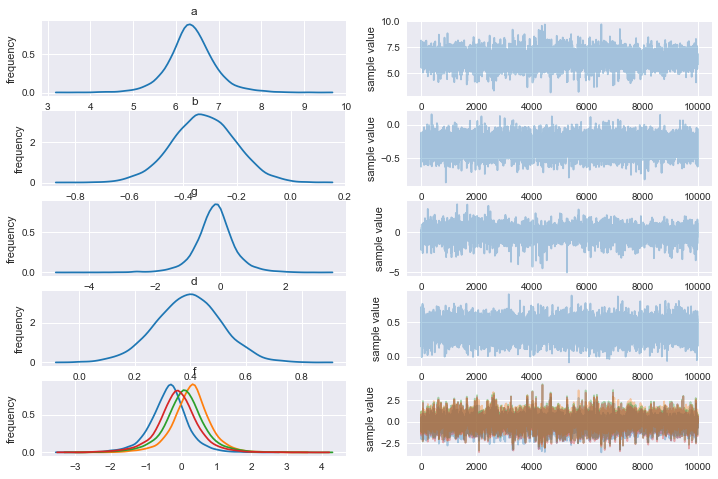

In [14]:
# plot parameter estimates
leaf_fit.plot(['a', 'b', 'g', 'd', 'f']);

There are several encouraging features of the fitted parameter estimates:

* The curves are smooth and unimodal, suggesting convergence and a well-behaved posterior distribution.
* The sample values are also well-behaved and do not 'flip' between extreme values

In [15]:
# summarise results
leaf_fit

Inference for Stan model: anon_model_e9dc8683e85b3f71a1137d158b6fda8d.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a           6.36    0.01   0.56   5.24   6.05   6.35   6.67   7.57   2301    1.0
b          -0.32  1.3e-3   0.12  -0.56   -0.4  -0.32  -0.24  -0.09   7848    1.0
g          -0.17    0.01   0.62  -1.48  -0.48  -0.15   0.16   1.11   2359    1.0
d           0.39  1.4e-3   0.12   0.15   0.32    0.4   0.47   0.63   7493    1.0
f[0]       -0.35    0.01   0.56  -1.55  -0.65  -0.33  -0.03   0.78   2353    1.0
f[1]        0.29    0.01   0.56   -0.9  -0.01   0.31    0.6   1.42   2355    1.0
f[2]        0.09    0.01   0.63  -1.26  -0.24   0.09   0.42   1.38   2422    1.0
f[3]       -0.09    0.01   0.63  -1.45  -0.43  -0.09   0.25   1.19   2448    1.0
mu_a         6.4    0.01   0.66   5.08   5.98   6.39    6.8   7.74   4184    1.0


The model fit above allows us to draw the following conclusions:

* The baseline recovery has median value 6.35 logCFU (50% credibility interval; 6.05:6.67)
* The effect of knocking out *etpD* with respect to wild-type Sakai is to reduce recovery (all values in 95% CI are negative). The median reduction is 0.32 logCFU (50% CI; -0.4:-0.24).
* There is no strong effect on recovery due to introduction of empty vector pSE380, with respect to the $\Delta etpD$ knockout (50% CI includes zero)
* The reintroduction of *etpD* increases recovery (all values in 95% CI are positive). The median increase is 0.4 logCFU (50% CI; 0.32:0.47)

### Root tissue<a id="root_fit"></a>

We next fit the model to root tissue

In [16]:
# fit model to root tissue
root_fit = run_fit(rootdata, treatment_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e9dc8683e85b3f71a1137d158b6fda8d NOW.


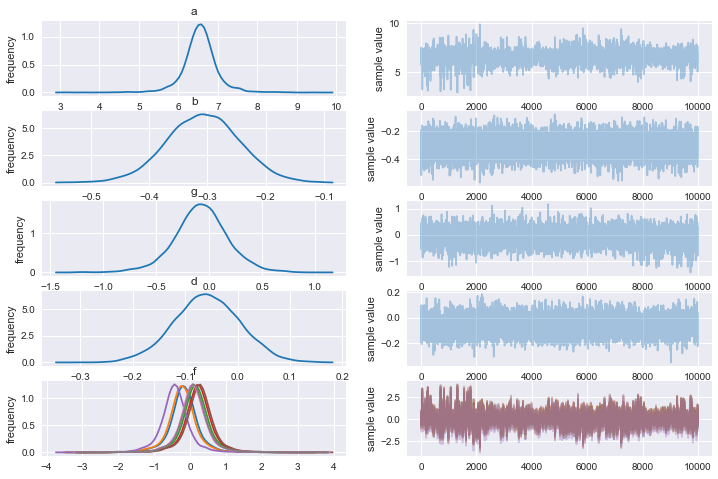

In [17]:
# plot parameter estimates
root_fit.plot(['a', 'b', 'g', 'd', 'f']);

In [18]:
# summarise results
root_fit

Inference for Stan model: anon_model_e9dc8683e85b3f71a1137d158b6fda8d.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a           6.55    0.01   0.46   5.65   6.33   6.55   6.76   7.49   1125    1.0
b          -0.31  7.1e-4   0.06  -0.43  -0.35  -0.31  -0.27  -0.18   7732    1.0
g          -0.07  3.9e-3   0.26  -0.61  -0.23  -0.07   0.08   0.44   4362    1.0
d          -0.06  7.0e-4   0.06  -0.18   -0.1  -0.06  -0.02   0.06   8210    1.0
f[0]       -0.17    0.01   0.46   -1.1  -0.38  -0.17   0.05   0.74   1125    1.0
f[1]       -0.22    0.01   0.46  -1.17  -0.43  -0.22-3.2e-4   0.68   1116    1.0
f[2]        0.15    0.01   0.46   -0.8  -0.07   0.15   0.37   1.06   1142    1.0
f[3]        0.22    0.01   0.46  -0.72-5.2e-4   0.22   0.44   1.13   1109    1.0
f[4]       -0.43    0.01   0.47  -1.35  -0.64  -0.43  -0.21    0.5   1225    1.0


### Parameter estimates
